In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import random

In [2]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0

        # Action space: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation space (Price, Balance, Shares Held)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data[self.current_step], self.balance, self.shares_held])

    def step(self, action):
        current_price = self.data[self.current_step]
        self.current_step += 1

        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.shares_held += shares_bought
            self.balance -= shares_bought * current_price
            self.total_shares_bought += shares_bought

        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.total_shares_sold += self.shares_held
            self.shares_held = 0

        self.total_profit = self.balance + (self.shares_held * current_price) - self.initial_balance
        reward = self.total_profit
        done = self.current_step >= len(self.data) - 1
        return self._next_observation(), reward, done, {}


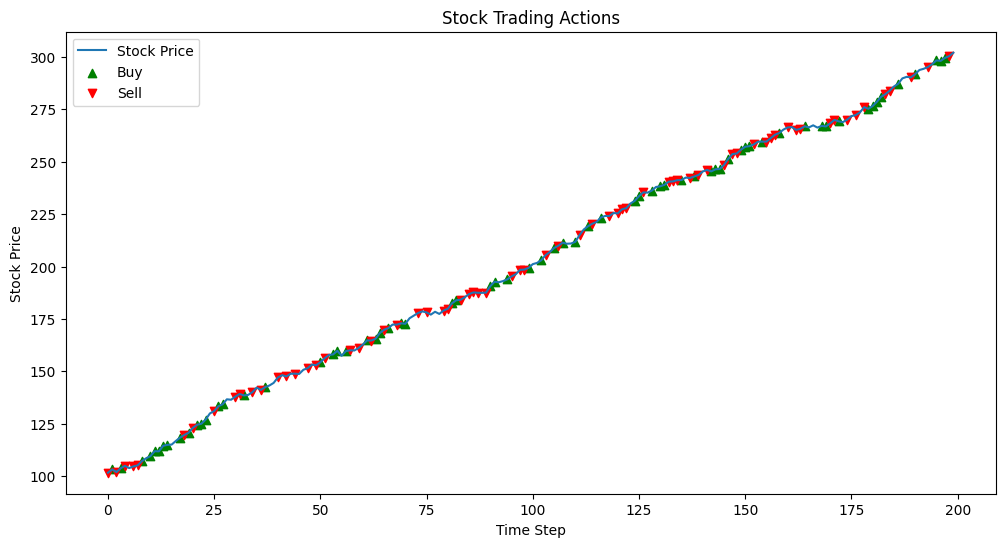

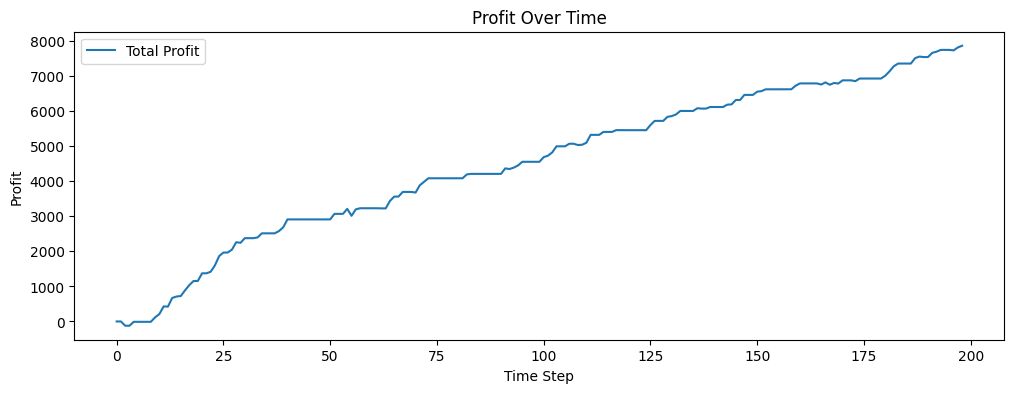

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0
        self.actions_history = []
        self.profit_history = []

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0
        self.actions_history = []
        self.profit_history = []
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data[self.current_step], self.balance, self.shares_held])

    def step(self, action):
        current_price = self.data[self.current_step]
        self.current_step += 1

        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.shares_held += shares_bought
            self.balance -= shares_bought * current_price
            self.total_shares_bought += shares_bought
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.total_shares_sold += self.shares_held
            self.shares_held = 0

        self.total_profit = self.balance + (self.shares_held * current_price) - self.initial_balance
        self.actions_history.append(action)
        self.profit_history.append(self.total_profit)

        reward = self.total_profit
        done = self.current_step >= len(self.data) - 1
        return self._next_observation(), reward, done, {}

def run_random_agent(env):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action selection
        state, reward, done, _ = env.step(action)

def plot_results(env, data):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Stock Price')
    buy_signals = [i for i, a in enumerate(env.actions_history) if a == 1]
    sell_signals = [i for i, a in enumerate(env.actions_history) if a == 2]
    plt.scatter(buy_signals, [data[i] for i in buy_signals], color='green', label='Buy', marker='^', alpha=1)
    plt.scatter(sell_signals, [data[i] for i in sell_signals], color='red', label='Sell', marker='v', alpha=1)
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title('Stock Trading Actions')
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(env.profit_history, label='Total Profit')
    plt.xlabel('Time Step')
    plt.ylabel('Profit')
    plt.legend()
    plt.title('Profit Over Time')
    plt.show()

# Example usage with synthetic data
data = np.cumsum(np.random.randn(200) + 1) + 100  # Simulated stock prices
env = StockTradingEnv(data)
run_random_agent(env)
plot_results(env, data)



In [3]:
# Example usage with synthetic data
data = np.cumsum(np.random.randn(100) + 1) + 100  # Simulated stock prices
env = StockTradingEnv(data)
obs = env.reset()

done = False
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, done, _ = env.step(action)
    print(f"Step: {env.current_step}, Action: {action}, Reward: {reward}")

Step: 1, Action: 1, Reward: 0.0
Step: 2, Action: 1, Reward: -46.36698474366676
Step: 3, Action: 1, Reward: 27.249518407990763
Step: 4, Action: 1, Reward: 30.10591596098857
Step: 5, Action: 2, Reward: 89.87225620328536
Step: 6, Action: 1, Reward: 89.87225620328536
Step: 7, Action: 0, Reward: 220.40734490272916
Step: 8, Action: 2, Reward: 208.30550155567653
Step: 9, Action: 1, Reward: 208.30550155567653
Step: 10, Action: 0, Reward: 158.69343093699172
Step: 11, Action: 2, Reward: 78.32663223195232
Step: 12, Action: 0, Reward: 78.32663223195232
Step: 13, Action: 1, Reward: 78.32663223195232
Step: 14, Action: 2, Reward: 142.44077879559518
Step: 15, Action: 1, Reward: 142.44077879559518
Step: 16, Action: 0, Reward: 316.01282110740976
Step: 17, Action: 0, Reward: 419.58788734195514
Step: 18, Action: 0, Reward: 448.7317396638973
Step: 19, Action: 0, Reward: 555.9378299466134
Step: 20, Action: 1, Reward: 699.6005415521595
Step: 21, Action: 0, Reward: 644.0586712181193
Step: 22, Action: 2, Rewar

In [4]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0

        # Action space: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation space (Price, Balance, Shares Held)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.total_profit = 0
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data[self.current_step], self.balance, self.shares_held])

    def step(self, action):
        current_price = self.data[self.current_step]
        self.current_step += 1

        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.shares_held += shares_bought
            self.balance -= shares_bought * current_price
            self.total_shares_bought += shares_bought

        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.total_shares_sold += self.shares_held
            self.shares_held = 0

        self.total_profit = self.balance + (self.shares_held * current_price) - self.initial_balance
        reward = self.total_profit
        done = self.current_step >= len(self.data) - 1
        return self._next_observation(), reward, done, {}

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Training setup
def train_dqn(env, episodes=1000, gamma=0.99, lr=0.001, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    model = DQN(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for episode in range(episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0)
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(model(state)).item()

            next_state, reward, done, _ = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor([reward], dtype=torch.float32)

            target = reward + gamma * torch.max(model(next_state)).detach()
            prediction = model(state)[0, action]
            loss = loss_fn(prediction, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 100 == 0:
            print(f"Episode {episode}, Epsilon: {epsilon:.4f}")

# Example usage with synthetic data
data = np.cumsum(np.random.randn(100) + 1) + 100  # Simulated stock prices
env = StockTradingEnv(data)
train_dqn(env)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, Epsilon: 0.9950
Episode 100, Epsilon: 0.6027
Episode 200, Epsilon: 0.3651
Episode 300, Epsilon: 0.2212
Episode 400, Epsilon: 0.1340
Episode 500, Epsilon: 0.0812
Episode 600, Epsilon: 0.0492
Episode 700, Epsilon: 0.0298
Episode 800, Epsilon: 0.0180
Episode 900, Epsilon: 0.0109


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, Epsilon: 0.9950, Profit: 7565.67964841667
Episode 100, Epsilon: 0.6027, Profit: 3155.3118512496058
Episode 200, Epsilon: 0.3651, Profit: 2472.472428364261
Episode 300, Epsilon: 0.2212, Profit: 14968.431278764197
Episode 400, Epsilon: 0.1340, Profit: 15006.594677093668


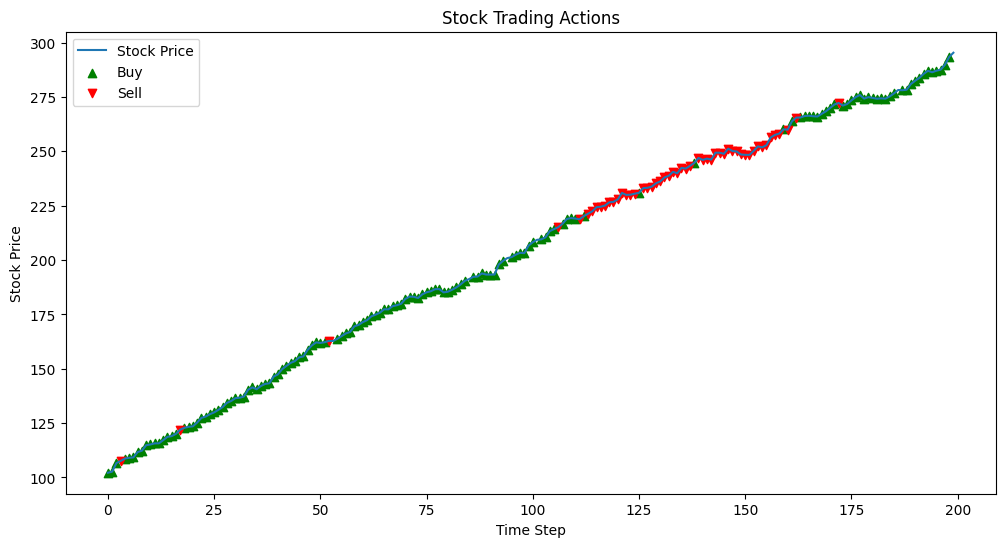

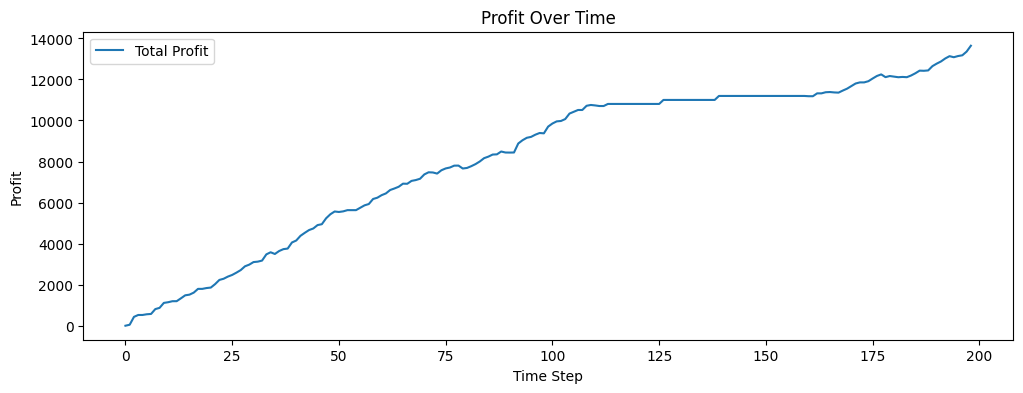

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_profit = 0
        self.actions_history = []
        self.profit_history = []

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_profit = 0
        self.actions_history = []
        self.profit_history = []
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data[self.current_step], self.balance, self.shares_held])

    def step(self, action):
        current_price = self.data[self.current_step]
        self.current_step += 1

        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.shares_held += shares_bought
            self.balance -= shares_bought * current_price
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0

        self.total_profit = self.balance + (self.shares_held * current_price) - self.initial_balance
        self.actions_history.append(action)
        self.profit_history.append(self.total_profit)

        reward = self.total_profit
        done = self.current_step >= len(self.data) - 1
        return self._next_observation(), reward, done, {}

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train_dqn(env, episodes=500):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    model = DQN(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    gamma = 0.99

    for episode in range(episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0)
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(model(state)).item()

            next_state, reward, done, _ = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor([reward], dtype=torch.float32)

            target = reward + gamma * torch.max(model(next_state)).detach()
            prediction = model(state)[0, action]
            loss = loss_fn(prediction, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 100 == 0:
            print(f"Episode {episode}, Epsilon: {epsilon:.4f}, Profit: {env.total_profit}")

def plot_results(env, data):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Stock Price')
    buy_signals = [i for i, a in enumerate(env.actions_history) if a == 1]
    sell_signals = [i for i, a in enumerate(env.actions_history) if a == 2]
    plt.scatter(buy_signals, [data[i] for i in buy_signals], color='green', label='Buy', marker='^', alpha=1)
    plt.scatter(sell_signals, [data[i] for i in sell_signals], color='red', label='Sell', marker='v', alpha=1)
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title('Stock Trading Actions')
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(env.profit_history, label='Total Profit')
    plt.xlabel('Time Step')
    plt.ylabel('Profit')
    plt.legend()
    plt.title('Profit Over Time')
    plt.show()

# Example usage with synthetic data
data = np.cumsum(np.random.randn(200) + 1) + 100  # Simulated stock prices
env = StockTradingEnv(data)
train_dqn(env)
plot_results(env, data)
